# Create Dataset and Dataloader

In [1]:
# CHECK CUDA
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name GeForce GTX 1060 6GB


In [2]:
#モジュールのimport
from torch.utils import data
from PIL import Image
import os
import sys
import numpy as np
from natsort import natsorted
import shutil
import glob
import albumentations as albu

import cv2
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')

In [4]:
da = __import__("pytorch_advanced.3_semantic_segmentation.utils.data_augumentation", fromlist=['object'])

In [5]:
#da = __import__("utils.data_augumentation", fromlist=['object'])

In [6]:
DATA_DIR = "../data"

In [7]:
class FixBinary(object):
    """Fix range of data into binary"""
    def __call__(self, img, anno_class_img):
        if anno_class_img.mode != "P":
            anno_class_img = anno_class_img.convert("P")
        return img, anno_class_img

In [8]:
from torchvision import transforms
class ToTensor(object):
    def __call__(self, img, anno_class_img):
        # img
        img = np.array(img)

        # annotation
        anno_class_img = np.array(anno_class_img)
        return img, anno_class_img
    

In [9]:
class DataTransform():
    """
    Attributes
    ----------
    input_size : int
    color_mean: (R, G, B)
    color_std: (R, G, B)anno_class_img
    """
    
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': da.Compose([
                FixBinary(),
                da.Scale(scale=[0.5, 1.5]),
                da.RandomRotation(angle=[-10, 10]),
                da.RandomMirror(),
                da.Resize(input_size),
                ToTensor()
                #da.Normalize_Tensor(color_mean, color_std) 
            ]),
            'val' : da.Compose([
                FixBinary(),
                da.Resize(input_size),
                ToTensor()
                #da.Normalize_Tensor(color_mean, color_std),
            ])
        }
        
    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
        """
        return self.data_transform[phase](img, anno_class_img)

In [10]:
class Dataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, preprocessing=None):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.preprocessing = preprocessing

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]

        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)
        
        if self.preprocessing:
            sample = self.preprocessing(image=img, mask=anno_class_img)
            img, anno = sample['image'], sample['mask']

        return img, anno_class_img

In [11]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        #albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [12]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## dataの読み込み

In [13]:
train_img_list = natsorted(glob.glob(DATA_DIR+"/train/img/*"))
train_anno_list = natsorted(glob.glob(DATA_DIR+"/train/anno/*"))

test_img_list = natsorted(glob.glob(DATA_DIR+"/test/img/*"))
test_anno_list = natsorted(glob.glob(DATA_DIR+"/test/anno/*"))

val_img_list = natsorted(glob.glob(DATA_DIR+"/valid/img/*"))
val_anno_list = natsorted(glob.glob(DATA_DIR+"/valid/anno/*"))

In [14]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.299, 0.244, 0.255)

train_dataset = Dataset(train_img_list, train_anno_list, phase="train",
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = Dataset(val_img_list, val_anno_list, phase="val",
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

In [15]:
np.random.randint(1,11)

10

In [27]:
image = Image.open(train_img_list[0])
print(np.array(image).shape)

(1080, 1920, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


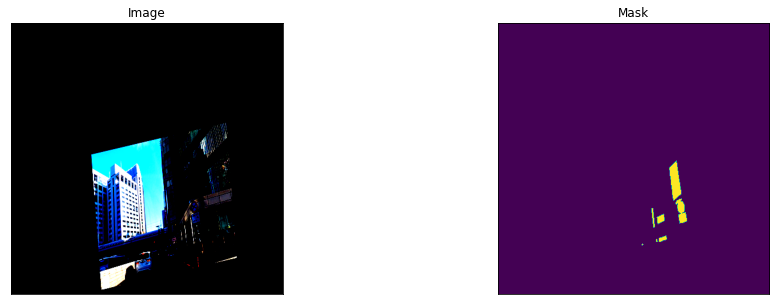

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


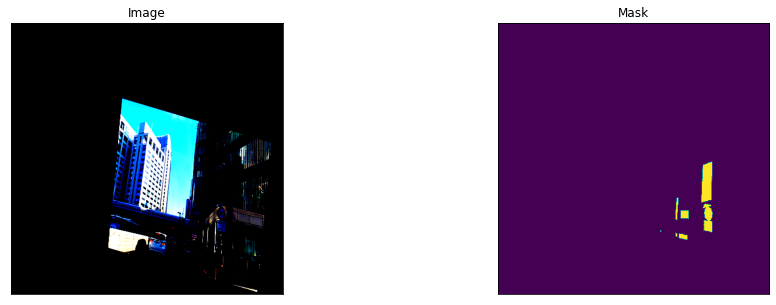

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


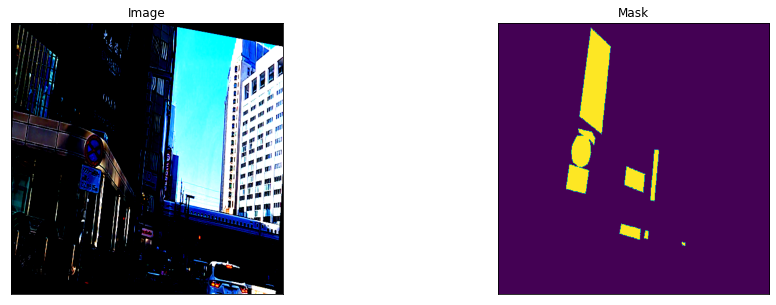

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


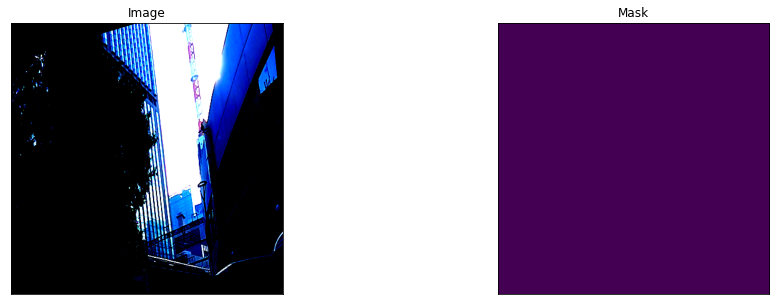

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


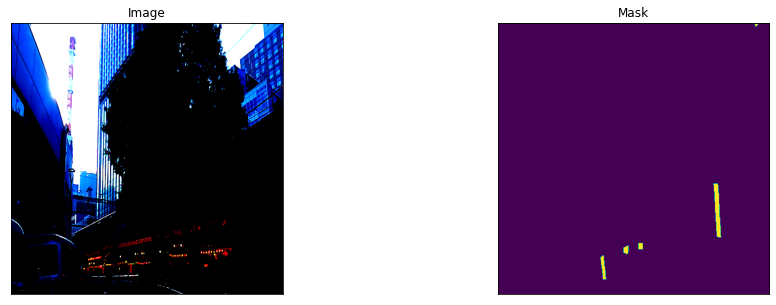

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


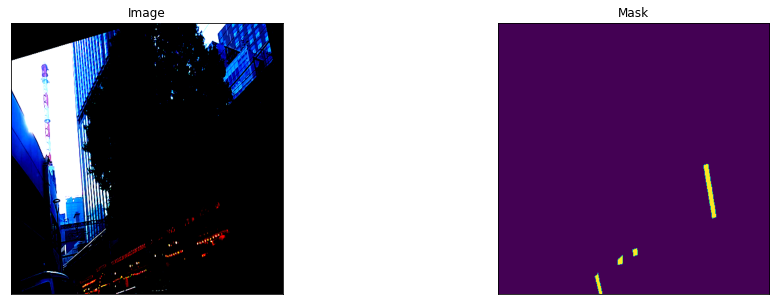

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


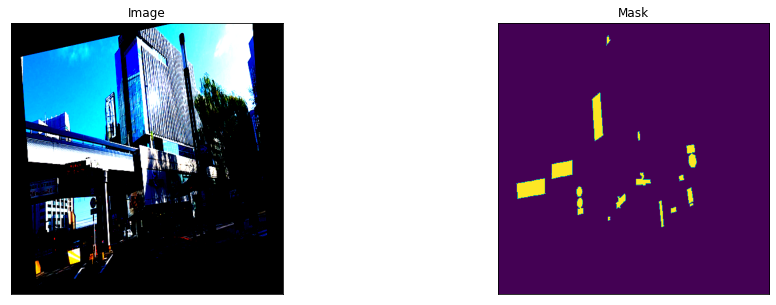

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


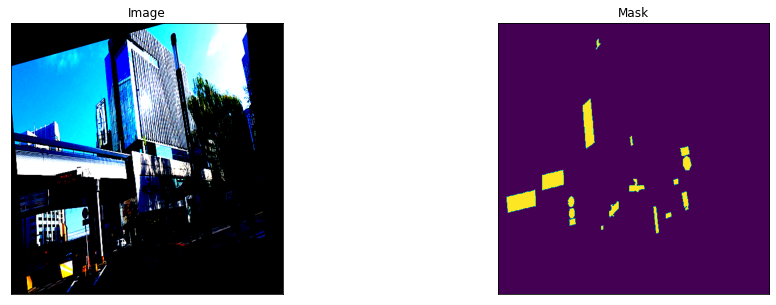

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


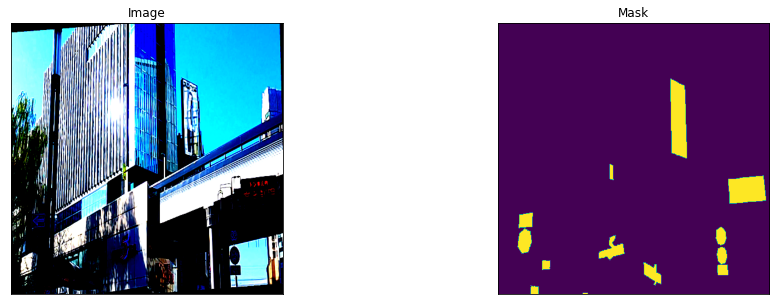

In [25]:
for i in range(3):
    ix = np.random.randint(1,100)
    for j in range(3):
        image, mask = train_dataset[ix]
        print(image.shape)
        visualize(image=image, mask=mask)

In [17]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=2, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
train_dataset = Dataset(train_img_list, train_anno_list, phase="train",
    preprocessing=get_preprocessing(preprocessing_fn),
    transform = DataTransform(
        input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = Dataset(val_img_list, val_anno_list, phase="val",
    preprocessing=get_preprocessing(preprocessing_fn),
    transform = DataTransform(
        input_size=475, color_mean=color_mean, color_std=color_std))

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [20]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [21]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [22]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [23]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
max_score = 0


#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_iou_score = []
valid_dice_loss = []
valid_iou_score = []


for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/55 [00:07<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[8, 475, 475, 3] to have 3 channels, but got 475 channels instead